# Pumpkin Seed Classification using SVMs



###  Introduction
This notebook performs classification on pumpkin seed data using various SVM models: **Linear**, **Polynomial**, and **RBF** kernels. We use **pipelines**, **scaling**, and **hyperparameter tuning** via GridSearchCV. The process and modeling approach is inspired by the examples in the "Hands-On Machine Learning" book by Aurélien Géron (notebook 05 - SVMs).

In [1]:

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import warnings




In [2]:
# Set random seed for reproducibility
np.random.seed(42)


# 1. Data Loading and Exploration

In [3]:

# Load the dataset
data = pd.read_csv('Pumpkin_Seeds_Dataset.csv')


In [4]:
# Convert only numeric columns (skip the Class column)
for col in data.columns:
    if col != 'Class' and data[col].dtype == object:
        # Only replace commas in numeric columns
        data[col] = data[col].str.replace(',', '', regex=False)
        data[col] = pd.to_numeric(data[col], errors='coerce')

In [5]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
    Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Convex_Area  \
0  56276     888.24             326.15             220.24        56831   
1  76631    1068.15             417.19             234.23        77280   
2  71623    1082.99             435.83             211.05        72663   
3  66458     992.05             381.56             222.53        67118   
4  66107     998.15             383.89             220.45        67117   

   Equiv_Diameter  Eccentricity  Solidity  Extent  Roundness  Aspect_Ration  \
0          267.68          0.74      0.99    0.75       0.90           1.48   
1          312.36          0.83      0.99    0.72       0.84           1.78   
2          301.98          0.87      0.99    0.74       0.77           2.07   
3          290.89          0.81      0.99    0.74       0.85           1.71   
4          290.12          0.82      0.99    0.68       0.83           1.74   

   Compactness       Class  
0         0.82  Çerç

In [6]:
# Check dataset information
print("\nDataset Information:")
print(data.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ration      2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB
None


In [7]:
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Convex_Area          0
Equiv_Diameter       0
Eccentricity         0
Solidity             0
Extent               0
Roundness            0
Aspect_Ration        0
Compactness          0
Class                0
dtype: int64


In [8]:
# Statistical summary of the dataset
print("\nStatistical Summary:")
print(data.describe())


Statistical Summary:
                Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count    2500.000000  2500.000000        2500.000000        2500.000000   
mean    80658.220800  1130.279552         456.601944         225.794964   
std     13664.510228   109.256501          56.235695          23.297258   
min     47939.000000   868.490000         320.840000         152.170000   
25%     70765.000000  1048.832500         414.957500         211.245000   
50%     79076.000000  1123.670000         449.500000         224.705000   
75%     89757.500000  1203.345000         492.737500         240.675000   
max    136574.000000  1559.450000         661.910000         305.820000   

         Convex_Area  Equiv_Diameter  Eccentricity     Solidity       Extent  \
count    2500.000000     2500.000000   2500.000000  2500.000000  2500.000000   
mean    81508.084400      319.334224      0.860844     0.989260     0.693188   
std     13764.092788       26.891992      0.045175     0.00327

In [9]:
# Check class distribution
print("\nClass Distribution:")
print(data['Class'].value_counts())


Class Distribution:
Class
Çerçevelik       1300
Ürgüp Sivrisi    1200
Name: count, dtype: int64


# 2. Exploratory Data Analysis

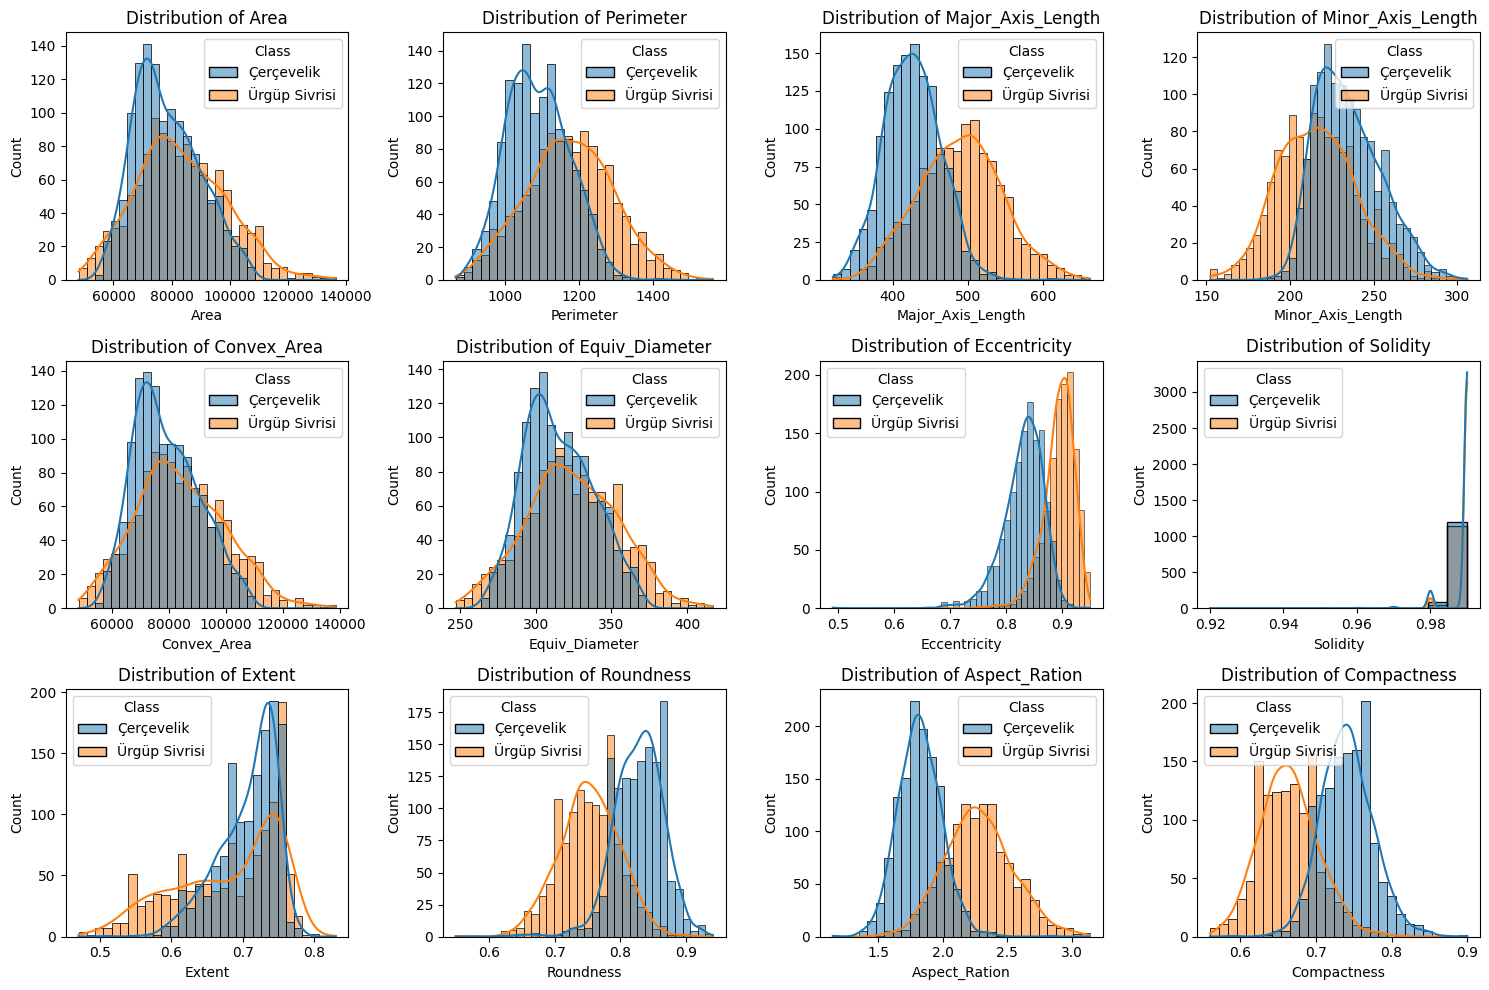

In [10]:
# Plot histograms for each feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.columns[:-1]):  # All columns except the Class column
    plt.subplot(3, 4, i+1)
    sns.histplot(data=data, x=column, hue='Class', kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

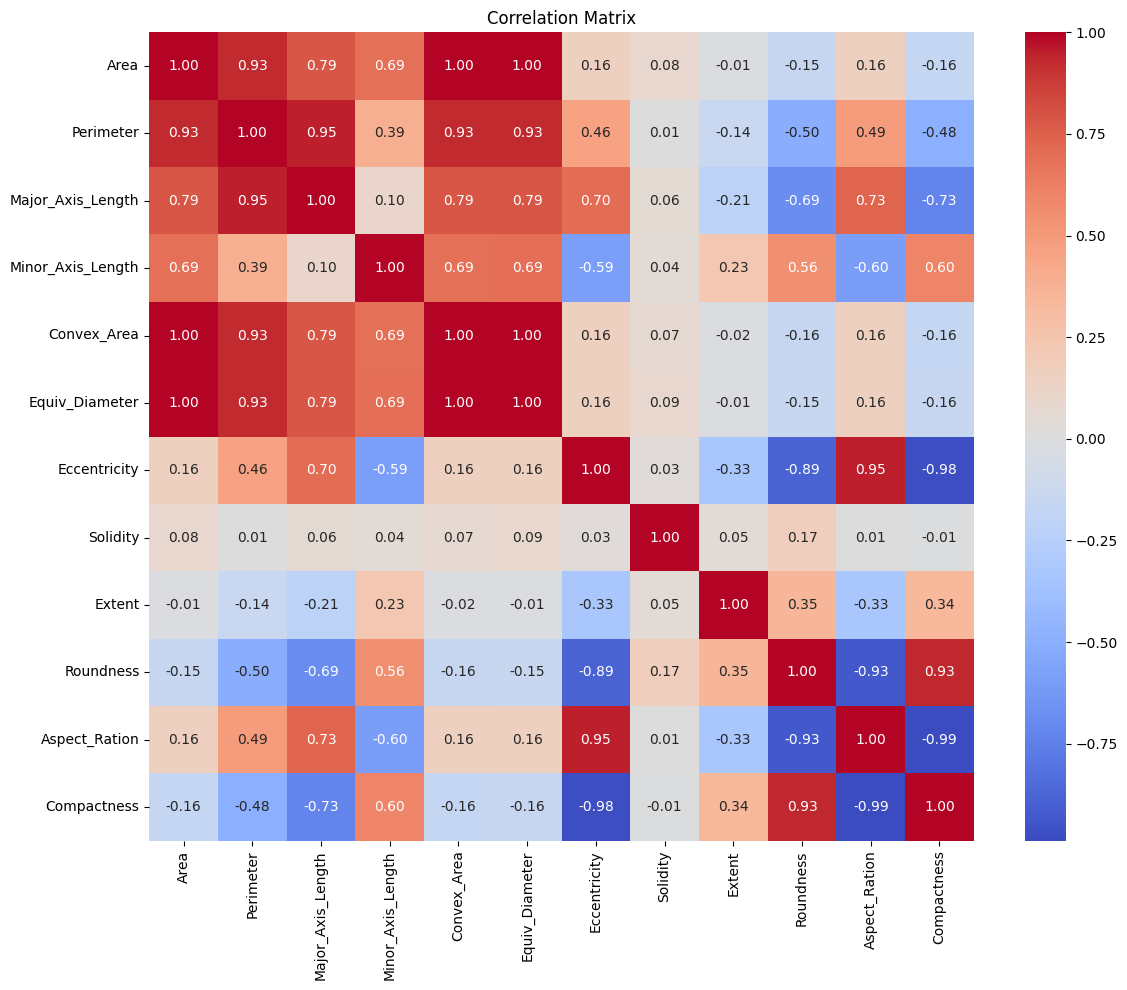

In [11]:
# Create correlation matrix only for numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns
correlation_matrix = data[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

<Figure size 1500x1000 with 0 Axes>

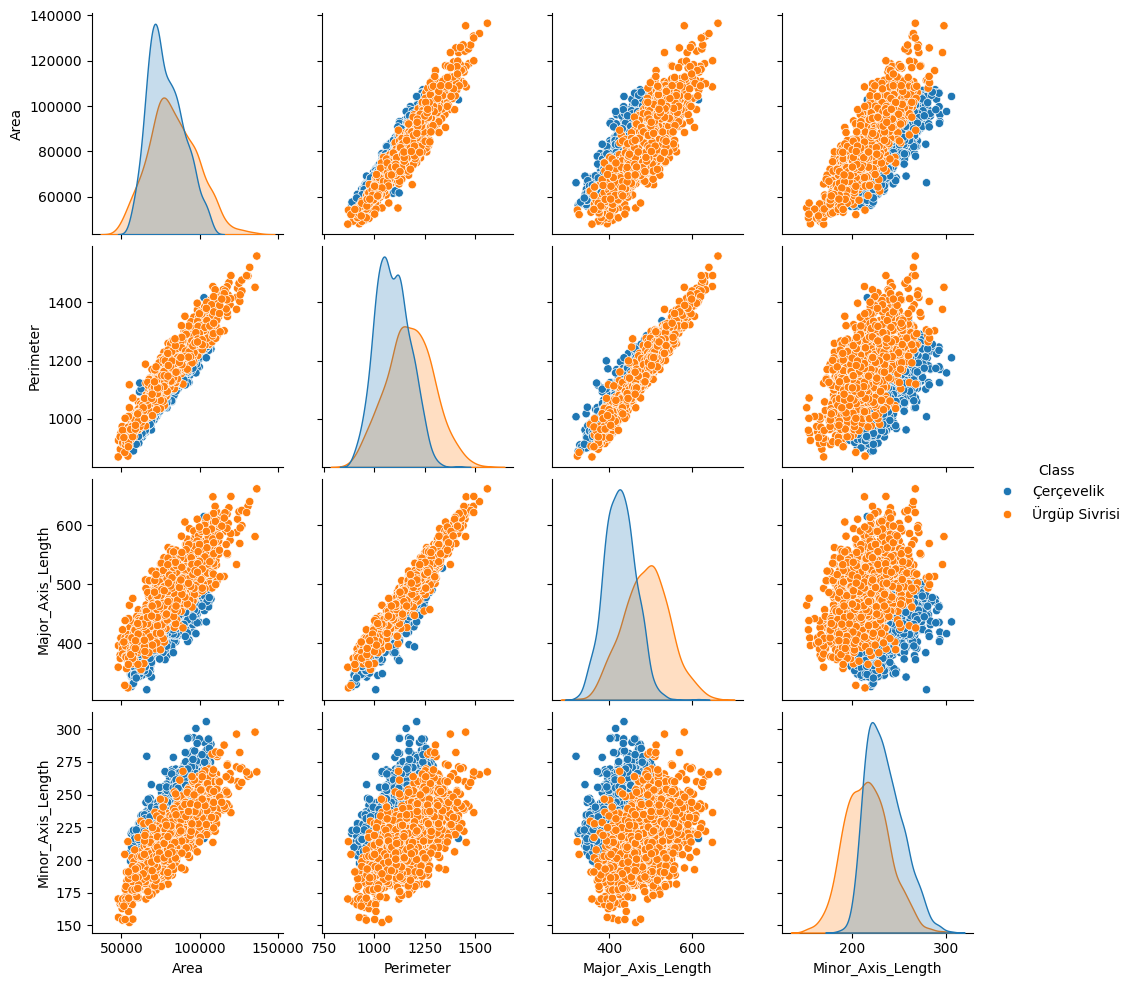

In [12]:
# Pairplot for selected features
plt.figure(figsize=(15, 10))
sns.pairplot(data, hue='Class', vars=data.columns[:4])  # Using first 4 features for clarity
plt.savefig('pairplot.png')
plt.show()

# 3. Data Preparation

In [13]:
# Separate features and target variable
X = data.drop('Class', axis=1)
y = data['Class']

In [14]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [15]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 1500 samples
Validation set size: 500 samples
Test set size: 500 samples


# 4. Demonstrate the importance of scaling

In [16]:
# 4.1 First, let's try SVM without scaling
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_no_scaling = svm_classifier.predict(X_val)
accuracy_no_scaling = accuracy_score(y_val, y_pred_no_scaling)
print(f"\nAccuracy without scaling: {accuracy_no_scaling:.4f}")


Accuracy without scaling: 0.8680


In [17]:
# 4.2 Now with scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

svm_classifier_scaled = SVC(kernel='linear', random_state=42)
svm_classifier_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = svm_classifier_scaled.predict(X_val_scaled)
accuracy_scaled = accuracy_score(y_val, y_pred_scaled)
print(f"Accuracy with scaling: {accuracy_scaled:.4f}")
print(f"Improvement: {(accuracy_scaled - accuracy_no_scaling) * 100:.2f}%")

Accuracy with scaling: 0.8760
Improvement: 0.80%


# 5. SVM Model Building with Pipeline

In [18]:
# 5.1 Linear SVM
print("\n--- Training Linear SVM ---")
linear_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=42))
])
# Define the parameter grid for linear SVM
param_grid_linear = {
    'svm__C': [0.1, 1, 10, 100]
}
# Grid search with cross-validation
grid_search_linear = GridSearchCV(
    linear_svm_pipeline, 
    param_grid_linear, 
    cv=5, 
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_linear.fit(X_train, y_train)


--- Training Linear SVM ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(kernel='linear',
                                            random_state=42))]),
             n_jobs=-1, param_grid={'svm__C': [0.1, 1, 10, 100]},
             scoring='accuracy', verbose=1)

In [19]:
# Results
print(f"Best parameters: {grid_search_linear.best_params_}")
print(f"Best cross-validation score: {grid_search_linear.best_score_:.4f}")

Best parameters: {'svm__C': 100}
Best cross-validation score: 0.8927


In [20]:
# Evaluate on validation set
y_val_pred_linear = grid_search_linear.predict(X_val)
val_accuracy_linear = accuracy_score(y_val, y_val_pred_linear)
print(f"Validation accuracy: {val_accuracy_linear:.4f}")
print("\nClassification report:")
print(classification_report(y_val, y_val_pred_linear))

Validation accuracy: 0.8860

Classification report:
               precision    recall  f1-score   support

   Çerçevelik       0.86      0.93      0.90       260
Ürgüp Sivrisi       0.92      0.83      0.88       240

     accuracy                           0.89       500
    macro avg       0.89      0.88      0.89       500
 weighted avg       0.89      0.89      0.89       500



In [21]:
# 5.2 Polynomial SVM
print("\n--- Training Polynomial SVM ---")
poly_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', random_state=42))
])

# Define the parameter grid for polynomial SVM
param_grid_poly = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0, 1, 2]
}

# Grid search with cross-validation
grid_search_poly = GridSearchCV(
    poly_svm_pipeline, 
    param_grid_poly, 
    cv=5, 
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_poly.fit(X_train, y_train)


--- Training Polynomial SVM ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(kernel='poly', random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100], 'svm__coef0': [0, 1, 2],
                         'svm__degree': [2, 3, 4]},
             scoring='accuracy', verbose=1)

In [22]:
# Results
print(f"Best parameters: {grid_search_poly.best_params_}")
print(f"Best cross-validation score: {grid_search_poly.best_score_:.4f}")

Best parameters: {'svm__C': 1, 'svm__coef0': 2, 'svm__degree': 2}
Best cross-validation score: 0.8873


In [23]:
# Evaluate on validation set
y_val_pred_poly = grid_search_poly.predict(X_val)
val_accuracy_poly = accuracy_score(y_val, y_val_pred_poly)
print(f"Validation accuracy: {val_accuracy_poly:.4f}")
print("\nClassification report:")
print(classification_report(y_val, y_val_pred_poly))

Validation accuracy: 0.8820

Classification report:
               precision    recall  f1-score   support

   Çerçevelik       0.86      0.93      0.89       260
Ürgüp Sivrisi       0.91      0.83      0.87       240

     accuracy                           0.88       500
    macro avg       0.89      0.88      0.88       500
 weighted avg       0.88      0.88      0.88       500



In [24]:
# 5.3 RBF SVM
print("\n--- Training RBF SVM ---")
rbf_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=42))
])

# Define the parameter grid for RBF SVM
param_grid_rbf = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.1, 1, 10]
}

# Grid search with cross-validation
grid_search_rbf = GridSearchCV(
    rbf_svm_pipeline, 
    param_grid_rbf, 
    cv=5, 
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_rbf.fit(X_train, y_train)


--- Training RBF SVM ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': ['scale', 'auto', 0.1, 1, 10]},
             scoring='accuracy', verbose=1)

In [25]:
# Results
print(f"Best parameters: {grid_search_rbf.best_params_}")
print(f"Best cross-validation score: {grid_search_rbf.best_score_:.4f}")

Best parameters: {'svm__C': 10, 'svm__gamma': 'scale'}
Best cross-validation score: 0.8860


In [26]:
# Evaluate on validation set
y_val_pred_rbf = grid_search_rbf.predict(X_val)
val_accuracy_rbf = accuracy_score(y_val, y_val_pred_rbf)
print(f"Validation accuracy: {val_accuracy_rbf:.4f}")
print("\nClassification report:")
print(classification_report(y_val, y_val_pred_rbf))

Validation accuracy: 0.8980

Classification report:
               precision    recall  f1-score   support

   Çerçevelik       0.88      0.93      0.91       260
Ürgüp Sivrisi       0.92      0.86      0.89       240

     accuracy                           0.90       500
    macro avg       0.90      0.90      0.90       500
 weighted avg       0.90      0.90      0.90       500



# 6. Model Comparison on Validation Set

In [27]:

print("\n--- Model Comparison on Validation Set ---")
print(f"Linear SVM accuracy: {val_accuracy_linear:.4f}")
print(f"Polynomial SVM accuracy: {val_accuracy_poly:.4f}")
print(f"RBF SVM accuracy: {val_accuracy_rbf:.4f}")


--- Model Comparison on Validation Set ---
Linear SVM accuracy: 0.8860
Polynomial SVM accuracy: 0.8820
RBF SVM accuracy: 0.8980


In [28]:
# Find the best model
best_val_accuracy = max(val_accuracy_linear, val_accuracy_poly, val_accuracy_rbf)
if best_val_accuracy == val_accuracy_linear:
    best_model = "Linear SVM"
    best_grid_search = grid_search_linear
elif best_val_accuracy == val_accuracy_poly:
    best_model = "Polynomial SVM"
    best_grid_search = grid_search_poly
else:
    best_model = "RBF SVM"
    best_grid_search = grid_search_rbf

print(f"\nBest model: {best_model} with validation accuracy: {best_val_accuracy:.4f}")


Best model: RBF SVM with validation accuracy: 0.8980


# 7. Final Model Evaluation on Test Set


--- Final Model Evaluation on Test Set ---
Test accuracy: 0.8520

Classification report on test set:
               precision    recall  f1-score   support

   Çerçevelik       0.83      0.89      0.86       251
Ürgüp Sivrisi       0.88      0.82      0.85       249

     accuracy                           0.85       500
    macro avg       0.85      0.85      0.85       500
 weighted avg       0.85      0.85      0.85       500



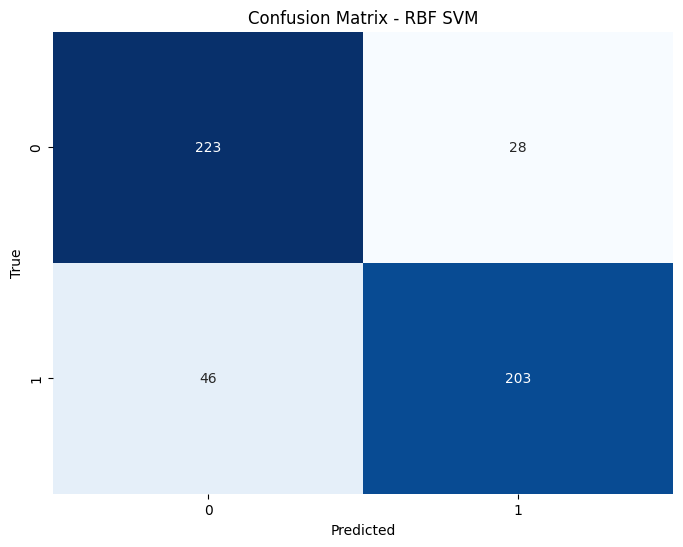

In [29]:

print("\n--- Final Model Evaluation on Test Set ---")
y_test_pred = best_grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nClassification report on test set:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model}')
plt.savefig('confusion_matrix.png')
plt.show()

# 8. Visualizing the Decision Boundaries (using PCA for dimensionality reduction)

In [30]:

print("\n--- Visualizing Decision Boundaries ---")

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


--- Visualizing Decision Boundaries ---
Explained variance ratio: [9.99894675e-01 9.72274918e-05]


In [31]:

# Split the reduced data
X_train_pca, X_test_pca = train_test_split(X_pca, test_size=0.2, random_state=42)
X_train_pca, X_val_pca = train_test_split(X_train_pca, test_size=0.25, random_state=42)

In [32]:
# Train best model type on PCA-transformed data
if best_model == "Linear SVM":
    kernel = 'linear'
    params = grid_search_linear.best_params_
    C = params['svm__C']
    pca_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel=kernel, C=C, random_state=42))
    ])
elif best_model == "Polynomial SVM":
    kernel = 'poly'
    params = grid_search_poly.best_params_
    C = params['svm__C']
    degree = params['svm__degree']
    coef0 = params['svm__coef0']
    pca_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel=kernel, C=C, degree=degree, coef0=coef0, random_state=42))
    ])
else:  # RBF SVM
    kernel = 'rbf'
    params = grid_search_rbf.best_params_
    C = params['svm__C']
    gamma = params['svm__gamma']
    pca_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel=kernel, C=C, gamma=gamma, random_state=42))
    ])

pca_model.fit(X_train_pca, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=10, random_state=42))])

In [33]:
# Convert class labels to numeric if they're strings
from sklearn.preprocessing import LabelEncoder

if isinstance(y, pd.Series) and y.dtype == object:
    label_encoder = LabelEncoder()
    y_numeric = label_encoder.fit_transform(y)
    print("Original classes:", label_encoder.classes_)
    print("Encoded as:", list(range(len(label_encoder.classes_))))
else:
    y_numeric = y

# Now try with the numeric labels
print("y_numeric data type:", y_numeric.dtype)

Original classes: ['Çerçevelik' 'Ürgüp Sivrisi']
Encoded as: [0, 1]
y_numeric data type: int64


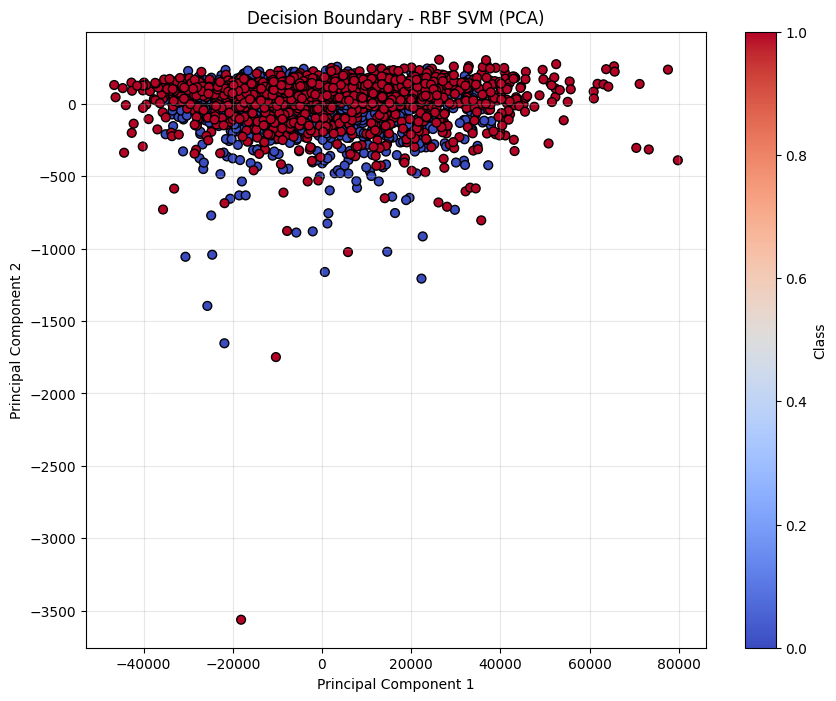

In [34]:
# Use simplified visualization approach with numeric labels
def simple_decision_plot(model, X, y_numeric):
    plt.figure(figsize=(10, 8))
    
    # Plot the data points with numeric class labels
    plt.scatter(X[:, 0], X[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=40)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f"Decision Boundary - {best_model} (PCA)")
    plt.colorbar(label='Class')
    plt.grid(True, alpha=0.3)
    return plt

# Try the simpler plot
simple_decision_plot(pca_model, X_pca, y_numeric)
plt.savefig('decision_boundary_simple.png')
plt.show()

# 9. Effect of C Parameter

In [35]:

print("\n--- Effect of C Parameter ---")

# Train models with different C values and plot the results
c_values = [0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
val_scores = []

for c in c_values:
    # Create a pipeline with the best kernel but varying C
    if best_model == "Linear SVM":
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='linear', C=c, random_state=42))
        ])
    elif best_model == "Polynomial SVM":
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='poly', C=c, degree=params['svm__degree'], 
                        coef0=params['svm__coef0'], random_state=42))
        ])
    else:  # RBF SVM
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='rbf', C=c, gamma=params['svm__gamma'], random_state=42))
        ])
    
    # Train the model
    model.fit(X_train, y_train)
    
       # Calculate scores
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    
    train_scores.append(train_score)
    val_scores.append(val_score)
    
    print(f"C = {c}: Training accuracy = {train_score:.4f}, Validation accuracy = {val_score:.4f}")
    


--- Effect of C Parameter ---
C = 0.01: Training accuracy = 0.8733, Validation accuracy = 0.8800
C = 0.1: Training accuracy = 0.8840, Validation accuracy = 0.8820
C = 1: Training accuracy = 0.8873, Validation accuracy = 0.8880
C = 10: Training accuracy = 0.9027, Validation accuracy = 0.8980
C = 100: Training accuracy = 0.9120, Validation accuracy = 0.8920
C = 1000: Training accuracy = 0.9333, Validation accuracy = 0.8780


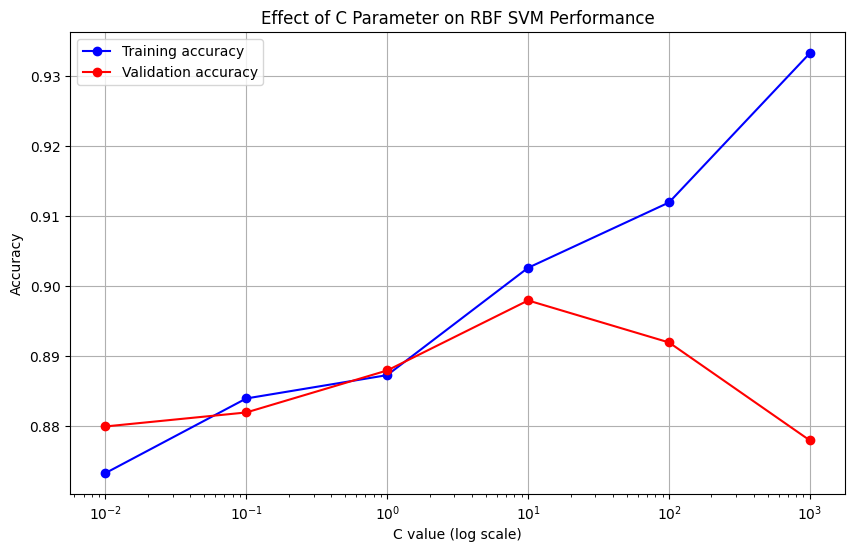

In [36]:
# Plot the effect of C
plt.figure(figsize=(10, 6))
plt.semilogx(c_values, train_scores, 'b-o', label='Training accuracy')
plt.semilogx(c_values, val_scores, 'r-o', label='Validation accuracy')
plt.xlabel('C value (log scale)')
plt.ylabel('Accuracy')
plt.title(f'Effect of C Parameter on {best_model} Performance')
plt.legend()
plt.grid(True)
plt.savefig('c_parameter_effect.png')
plt.show()

# 10. Feature Importance Analysis (for Linear SVM model)


--- Feature Importance Analysis (Linear SVM) ---
Feature importance (based on coefficient magnitude):
              Feature  Coefficient
0                Area    30.747220
4         Convex_Area   -21.593154
5      Equiv_Diameter   -12.555703
2   Major_Axis_Length    10.201645
1           Perimeter    -7.876347
3   Minor_Axis_Length     4.239957
9           Roundness    -2.350048
10      Aspect_Ration     1.995415
6        Eccentricity    -1.322091
11        Compactness     0.883677
7            Solidity    -0.160779
8              Extent     0.023412


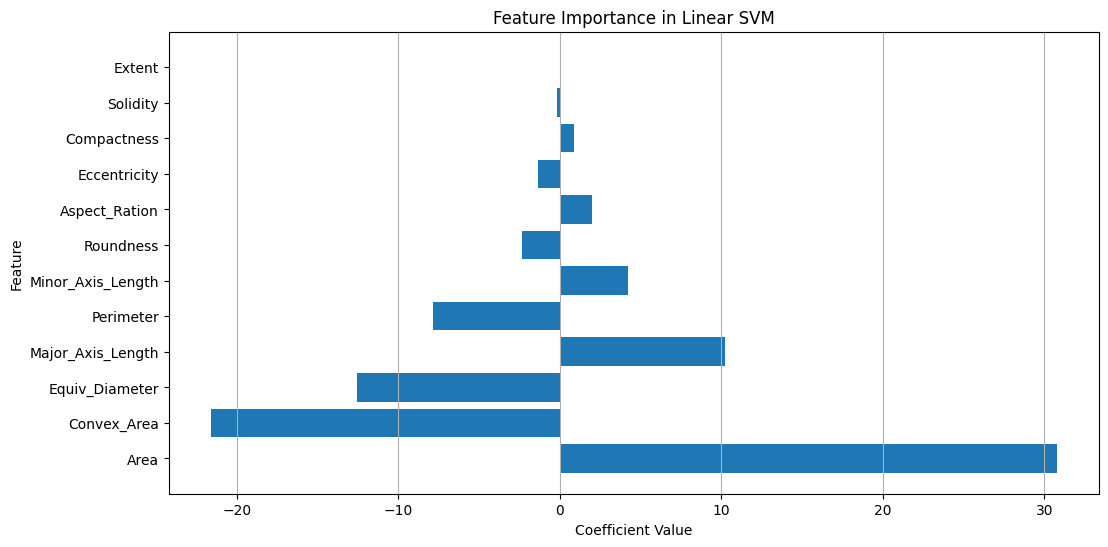

In [37]:

print("\n--- Feature Importance Analysis (Linear SVM) ---")

# Get the best Linear SVM model
best_linear_model = grid_search_linear.best_estimator_.named_steps['svm']

# Get feature coefficients
coefficients = best_linear_model.coef_[0]

# Get feature names
feature_names = X.columns

# Create a DataFrame with feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute coefficient value
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("Feature importance (based on coefficient magnitude):")
print(feature_importance[['Feature', 'Coefficient']])

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear SVM')
plt.grid(True, axis='x')
plt.savefig('feature_importance.png')
plt.show()

# 11. Summary and Conclusion

In [38]:

print("\n--- Summary and Conclusion ---")
print(f"Best model: {best_model}")
if best_model == "Linear SVM":
    print(f"Best parameters: C = {grid_search_linear.best_params_['svm__C']}")
elif best_model == "Polynomial SVM":
    print(f"Best parameters: C = {grid_search_poly.best_params_['svm__C']}, " +
          f"degree = {grid_search_poly.best_params_['svm__degree']}, " +
          f"coef0 = {grid_search_poly.best_params_['svm__coef0']}")
else:  # RBF SVM
    print(f"Best parameters: C = {grid_search_rbf.best_params_['svm__C']}, " +
          f"gamma = {grid_search_rbf.best_params_['svm__gamma']}")

print(f"\nTraining accuracy: {best_grid_search.score(X_train, y_train):.4f}")
print(f"Validation accuracy: {best_val_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nKey observations:")
print("1. The importance of scaling in SVM models")
print(f"   - Without scaling: {accuracy_no_scaling:.4f}")
print(f"   - With scaling: {accuracy_scaled:.4f}")
print(f"   - Improvement: {(accuracy_scaled - accuracy_no_scaling) * 100:.2f}%")

print(f"\n2. {best_model} performed best for this dataset")

print("\n3. Effect of C parameter:")
print("   - Low C values: More regularization, simpler decision boundary")
print("   - High C values: Less regularization, more complex decision boundary")

print("\n4. The final model achieved good performance on unseen test data")
print(f"   - Test accuracy: {test_accuracy:.4f}")




--- Summary and Conclusion ---
Best model: RBF SVM
Best parameters: C = 10, gamma = scale

Training accuracy: 0.9027
Validation accuracy: 0.8980
Test accuracy: 0.8520

Key observations:
1. The importance of scaling in SVM models
   - Without scaling: 0.8680
   - With scaling: 0.8760
   - Improvement: 0.80%

2. RBF SVM performed best for this dataset

3. Effect of C parameter:
   - Low C values: More regularization, simpler decision boundary
   - High C values: Less regularization, more complex decision boundary

4. The final model achieved good performance on unseen test data
   - Test accuracy: 0.8520


# Conclusion :
This notebook demonstrated the application of different SVM models for classifying pumpkin seeds. We explored data preparation, scaling, hyperparameter tuning using GridSearchCV, and final model evaluation. The pipeline approach ensures proper scaling and model integration.


## Group Members and Contributions

### **Subramaniyamge Ruwani Rangika Weerasinghe (2305168)**  
- Led the data preprocessing and exploratory data analysis.  
- Handled the data visualization part using matplotlib and seaborn.  
- Ensured the dataset was split correctly into training, validation, and test sets.  
- Assisted in creating the final summary and conclusion of the notebook.  

### **Ketiyape Samarasekara Kasunki Samarasekara (2304486)**  
- Focused on model building using Linear, Polynomial, and RBF SVMs.  
- Implemented Pipeline, StandardScaler, and GridSearchCV for model optimization.  
- Took charge of the model comparison and hyperparameter tuning sections.  
- Contributed to testing the effect of different C values and final model evaluation.  


> Both members collaborated on discussion, model comparison, and final video explanation.